In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numba as nb
import imageio
import shutil
import os

from tqdm.notebook import tqdm

sns.set(font_scale=1.1, rc={
    'figure.figsize': (10, 6),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

%matplotlib inline
%config InlineBackend.figure_format = "svg"

In [143]:
class JapaneseTreeFrogs:
    def __init__(self, agents: int, a: float, omega: float, dt: float = 0.1):
        self.name = f"JTF_{a}"
        self.phaseTheta = np.random.random(agents) * 2 * np.pi
        self.a = a
        self.omega = omega * np.ones(agents)
        self.dt = dt

    @staticmethod
    @nb.njit
    def _delta_theta(phaseTheta):
        dim = phaseTheta.shape[0]
        subTheta = phaseTheta - np.repeat(phaseTheta, dim).reshape(dim, dim)

        deltaTheta = np.zeros((dim, dim - 1))
        for i in np.arange(dim):
            deltaTheta[i, :i], deltaTheta[i, i:] = subTheta[i, :i], subTheta[i, i + 1 :]
        return deltaTheta
    
    @property
    def deltaTheta(self) -> np.ndarray:
        """Phase difference between agents"""
        return self._delta_theta(self.phaseTheta)

    @property
    def H(self) -> float:
        return self.a * np.sin(self.deltaTheta)

    @staticmethod
    @nb.njit
    def _update(phaseTheta: np.ndarray, omega: np.ndarray, H: float, dt: float):
        pointTheta = omega + np.sum(H, axis=1)
        phaseTheta = np.mod(phaseTheta + pointTheta * dt, 2 * np.pi)
        return phaseTheta

    def update(self):
        self.phaseTheta = self._update(self.phaseTheta, self.omega, self.H, self.dt)

    def plot(self):
        plt.figure(figsize=(6, 6))
        plt.scatter(np.cos(self.phaseTheta), np.sin(self.phaseTheta), s=100)
        # draw circle
        circle = plt.Circle((0, 0), 1, color='black', fill=False)
        plt.gcf().gca().add_artist(circle)
        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)
        plt.show()

class JapaneseTreeFrogsH2(JapaneseTreeFrogs):
    def __init__(self, agents: int, a: float, b: float, omega: float, dt: float = 0.1):
        super().__init__(agents, a, omega, dt)
        self.name = f"H_a{a}_b{b}"
        self.b = b

    @property
    def H(self) -> float:
        return self.a * np.sin(self.deltaTheta) + self.b * np.sin(2 * self.deltaTheta)
    
class JapaneseTreeFrogsH3(JapaneseTreeFrogs):
    def __init__(self, agents: int, a: float, b: float, c: float, omega: float, dt: float = 0.1):
        super().__init__(agents, a, omega, dt)
        self.name = f"H_a{a}_b{b}_c{c}"
        self.b = b
        self.c = c

    @property
    def H(self) -> float:
        return self.a * np.sin(self.deltaTheta) + self.b * np.sin(2 * self.deltaTheta) + self.c * np.cos(self.deltaTheta)

In [19]:
def plot_phase(phase: np.ndarray, title: str):
    plt.figure(figsize=(6, 6))
    plt.scatter(np.cos(phase), np.sin(phase), s=100)
    # draw circle
    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    plt.gcf().gca().add_artist(circle)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.title(title)

In [20]:
def generate_gif(model: JapaneseTreeFrogs, T: int = 1000):
    if os.path.exists("./images"):
        shutil.rmtree("./images")
    os.mkdir("./images")

    images = []

    for i in tqdm(range(T)):
        model.update()
        if i % 5 == 0:
            plot_phase(model.phaseTheta, f"t = {i * 0.5}")
            plt.savefig(f"./images/{i}.png")
            plt.close()
            images.append(f"./images/{i}.png")

    images = [imageio.imread(image) for image in images]
    imageio.mimsave(f'./{model.name}.gif', images)

In [ ]:
generate_gif(JapaneseTreeFrogs(agents=2, a=1, omega=1.0), T=1000)

In [48]:
generate_gif(JapaneseTreeFrogsH2(agents=3, a=-5, b=1, omega=1.0), T=200)

  0%|          | 0/200 [00:00<?, ?it/s]

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


In [113]:
class PhiPsiH2:
    def __init__(self, a: float, b: float, dt: float = 0.1):
        self.a = a
        self.b = b
        self.dt = dt
        self.phi = np.random.random() * 2 * np.pi
        self.psi = np.random.random() * 2 * np.pi

    def H(self, theta) -> float:
        return self.a * np.sin(theta) + self.b * np.sin(2 * theta)

    def update(self):
        pointPhi = self.H(-self.phi) + self.H(-self.phi-self.psi) - self.H(self.phi) - self.H(-self.psi)
        pointPsi = self.H(self.phi) + self.H(-self.psi) - self.H(self.phi+self.psi) - self.H(self.psi)
        self.phi = self.phi + pointPhi * self.dt
        self.psi = self.psi + pointPsi * self.dt

class PhiPsiH3(PhiPsiH2):
    def __init__(self, a: float, b: float, c: float, dt: float = 0.1):
        super().__init__(a, b, dt)
        self.c = c

    def H(self, theta) -> float:
        return self.a * np.sin(theta) + self.b * np.sin(2 * theta) + self.c * np.cos(theta)

<font face="Times New Roman">

$$
H(x) = a\sin(x) + b\sin(2x), \ \ \ a=-5\ b=1
$$

<font face="Times New Roman">

## 2 frogs

  0%|          | 0/200 [00:00<?, ?it/s]

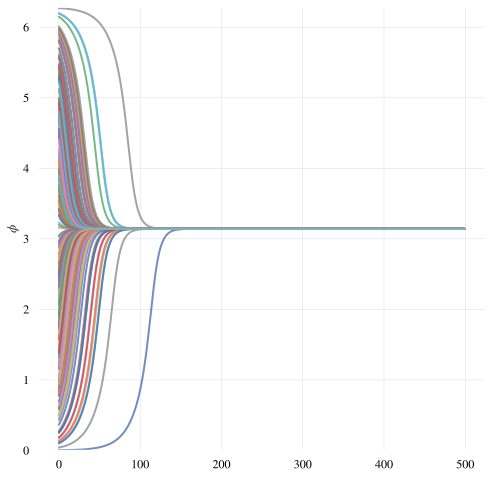

In [142]:
location = 10
T = 500
iters = 200
phis = []
for i in tqdm(range(iters)):
    phis.append([])
    model = JapaneseTreeFrogsH2(agents=2, a=-5, b=1, omega=1, dt=0.01)
    for _ in range(T):
        model.update()
        phis[i].append(np.mod(model.phaseTheta[0] - model.phaseTheta[1], 2 * np.pi))
        
plt.figure(figsize=(8, 8))
plt.ylim(0, 2 * np.pi)
plt.ylabel(r"$\phi$")

for i in range(iters):
    plt.plot(phis[i], linewidth=2, alpha=0.8)

<font face="Times New Roman">

## 3 frogs

  0%|          | 0/200 [00:00<?, ?it/s]

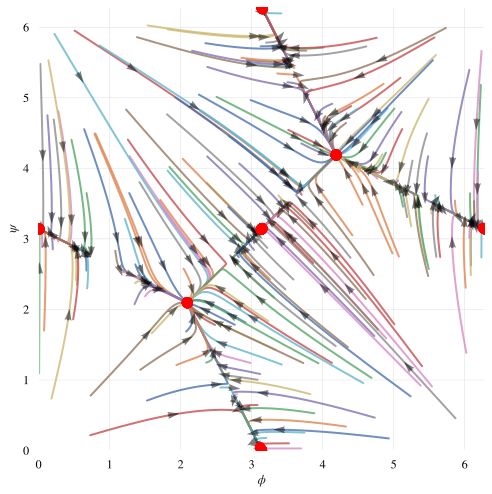

In [135]:
location = 10
T = 500
iters = 200
phis = []
psis = []
for i in tqdm(range(iters)):
    phis.append([])
    psis.append([])
    model = PhiPsiH2(a=-5, b=1, dt=0.01)
    for _ in range(T):
        model.update()
        phis[i].append(model.phi)
        psis[i].append(model.psi)

plt.figure(figsize=(8, 8))
plt.xlim(0, 2 * np.pi)
plt.ylim(0, 2 * np.pi)
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\psi$")

for i in range(iters):
    plt.plot(phis[i], psis[i], linewidth=2, alpha=0.8)
    plt.scatter(phis[i][-1], psis[i][-1], s=100, color="red", zorder=10)
    vx = np.diff(phis[i])[location]
    vy = np.diff(psis[i])[location]
    length = np.sqrt(vx ** 2 + vy ** 2) * 10
    plt.quiver(phis[i][location], psis[i][location], vx / length, vy / length, angles='xy', scale_units='xy', scale=0.6, color="black", zorder=5, alpha=0.5)

<font face="Times New Roman">

$$
H(x) = a\sin(x) + b\sin(2x) + c\cos(x), \ \ \ a=-5\ b=1\ c=0.1
$$

<font face="Times New Roman">

## 2 frogs

  0%|          | 0/200 [00:00<?, ?it/s]

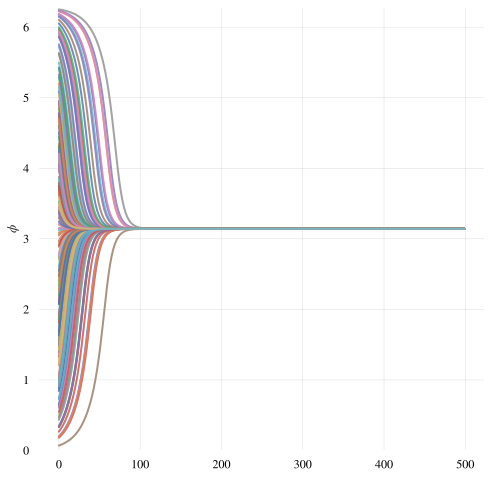

In [144]:
location = 10
T = 500
iters = 200
phis = []
for i in tqdm(range(iters)):
    phis.append([])
    model = JapaneseTreeFrogsH3(agents=2, a=-5, b=1, c=0.1, omega=1, dt=0.01)
    for _ in range(T):
        model.update()
        phis[i].append(np.mod(model.phaseTheta[0] - model.phaseTheta[1], 2 * np.pi))
        
plt.figure(figsize=(8, 8))
plt.ylim(0, 2 * np.pi)
plt.ylabel(r"$\phi$")

for i in range(iters):
    plt.plot(phis[i], linewidth=2, alpha=0.8)

<font face="Times New Roman">

## 3 frogs

  0%|          | 0/200 [00:00<?, ?it/s]

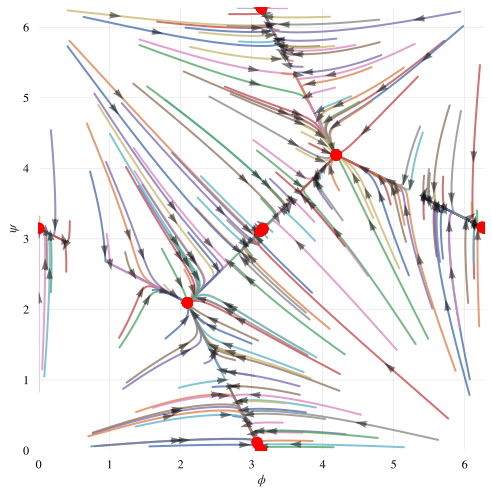

In [137]:
location = 10
T = 500
iters = 200
phis = []
psis = []
for i in tqdm(range(iters)):
    phis.append([])
    psis.append([])
    model = PhiPsiH3(a=-5, b=1, c=0.1, dt=0.01)
    for _ in range(T):
        model.update()
        phis[i].append(model.phi)
        psis[i].append(model.psi)

plt.figure(figsize=(8, 8))
plt.xlim(0, 2 * np.pi)
plt.ylim(0, 2 * np.pi)
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\psi$")

for i in range(iters):
    plt.plot(phis[i], psis[i], linewidth=2, alpha=0.8)
    plt.scatter(phis[i][-1], psis[i][-1], s=100, color="red", zorder=10)
    vx = np.diff(phis[i])[location]
    vy = np.diff(psis[i])[location]
    length = np.sqrt(vx ** 2 + vy ** 2) * 10
    plt.quiver(phis[i][location], psis[i][location], vx / length, vy / length, angles='xy', scale_units='xy', scale=0.6, color="black", zorder=5, alpha=0.5)